In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Notebooks/thesisrc.py')
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

from scipy import ndimage 
from skimage import io, img_as_float
from skimage.transform import rotate

import pickle
import os, glob, shutil, random

In [2]:
img_dir = '/Users/nik/Dropbox/cnt_filter/original'
test_dir = '/Users/nik/Dropbox/cnt_filter/test'
fig_dir = '/Users/nik/Dropbox/Repos/thesis/figures/chapter3'
os.chdir(test_dir)

In [3]:
# import the test data set
tubes = img_as_float(np.load('individual_cnt_imgs.npy'))
tset = tubes[[0,3,19,27,48]] 

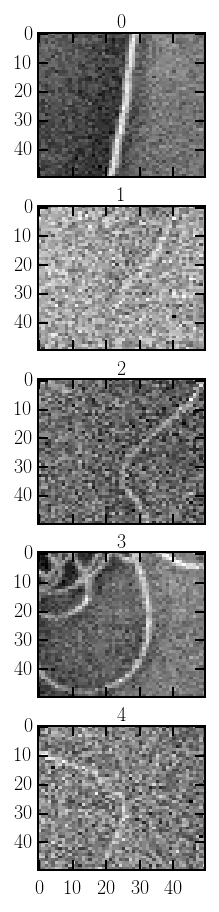

In [4]:
# Here are the unedited images
fig, axs = plt.subplots(5,1,sharex = True, sharey=False, 
                        figsize=(1*3,5*3))
axs = axs.flat

for i, im in enumerate(tset):
    axs[i].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'nearest')
    axs[i].set_title(i)

In [5]:
# all of the functions I need to create the filter

def sinc(x, k, a):
    """ return a sinc function cutoff at +/-2*pi/a """
    
    iz = int(len(x)/2)
    il = iz-np.ceil(2.0*np.pi/k)
    iu = iz+np.ceil(2.0*np.pi/k)+1
    
    s = np.sin(k*x)/(k*x) # function to start with
    s[iz] = 1 # numpy doesn't know about limits
    s[il:iu] -= s[il:iu].mean()
    s[0:il] = 0; s[iu:] = 0
    return a*s

def build_kernel(k, a, L, N):
    """ N is an odd integer. The kernel will be size NxN with (x,y) = (0,0)
        in the center. """
    x = np.arange(-(N/2),(N/2)+1,1)
    kernel = np.zeros((N,N), dtype = np.float)
    kernel[abs(x)<L/2.0, :] = sinc(x, k, a)
    return kernel

def build_filter_bank(k, a, L, N, R):
    """ builds the nanotube filter bank 
            k -- inverse length for sinc function
            a -- height of sinc function
            L -- nanotube length to search for
            N -- size of filter matrix
            R -- number of rotations """
    
    rotations = rotations = np.linspace(0,180,R+1)[:-1]

    fbank = np.zeros((len(rotations),N,N))
    kernel = build_kernel(k, a, L, N)
    for i, r in enumerate(rotations):
        fbank[i] = ndimage.rotate(kernel, r, reshape=False, mode='nearest')
    return fbank

def apply_filter(im, fbank, threshold):
    """ apply the bank of filters to a given image """

    result = np.zeros(im.shape)
    for i, f in enumerate(fbank):
        imfilt = ndimage.convolve(im, fbank[i], mode='nearest')
        result += imfilt>threshold
    return result

In [6]:
#>>> my_task = MyTask(1, 2, 3, 4)
#>>> my_task(image)
# It didn't work? Maybe try a different value for a.
#>>> my_task.a = 1.1
#>>> my_task(image)
#>>> my_task(image2)
#>>> my_task(image3)

class ImgFilter(object):

    def __init__(self, k, a, L, N, R, threshold):
        self.k = k
        self.a = a
        self.L = L
        self.N = N
        self.R = R
        self.threshold = threshold
        
    def __call__(self, im):
        bank = build_filter_bank(self.k, self.a, self.L, self.N, self.R)
        return apply_filter(im, bank, self.threshold)

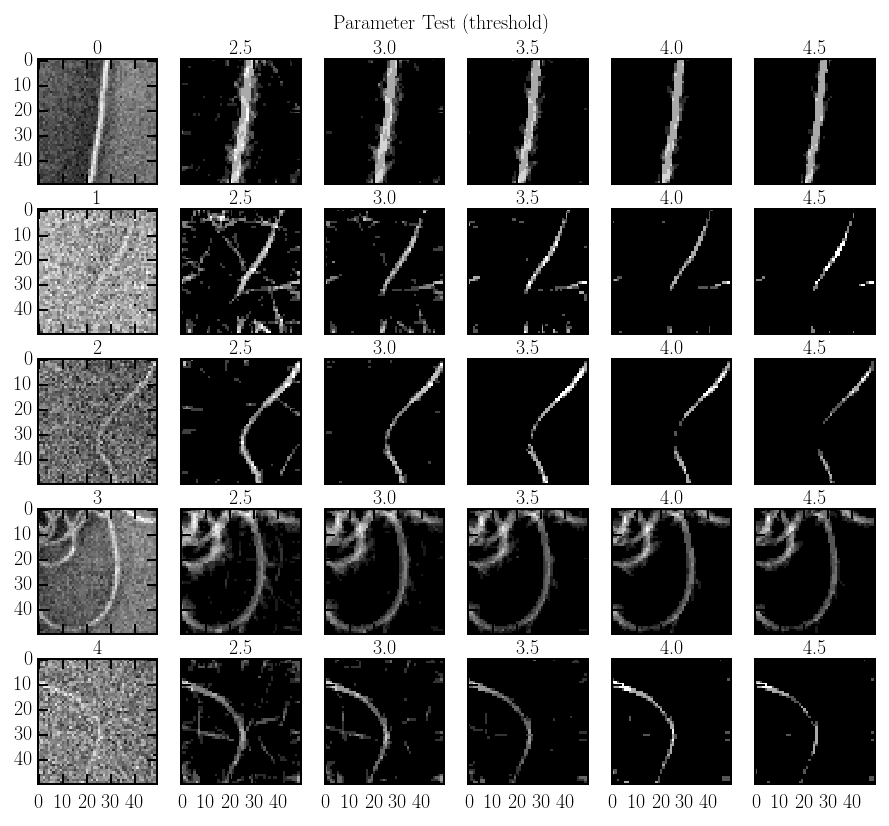

In [9]:
### THRESHOLD ###

# initial variables
k = 1.7
a = 10.0
L = 16.0
N = 25
R = 15
threshold = 3.75

mfilter = ImgFilter(k, a, L, N, R, threshold)

# variable to test
thresholds = [2.5,3.0,3.5,4.0,4.5]

fig, axs = plt.subplots(5,6,sharex = True, sharey=True, 
                        figsize=(6*2.5,5*2.5))

for i, im in enumerate(tset):
    for j in range(6):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title(i)
        else:
            mfilter.threshold = thresholds[j-1]
            axs[i,j].imshow(mfilter(im), cmap = plt.cm.gray, aspect = 'auto', interpolation = 'nearest')
            axs[i,j].set_title('{}'.format(thresholds[j-1]))
fig.suptitle('Parameter Test (threshold)')
fig.subplots_adjust(top=0.93)
fig.savefig(os.path.join(fig_dir, 'filter_parameter_test.pdf'), format='pdf', dpi=300)

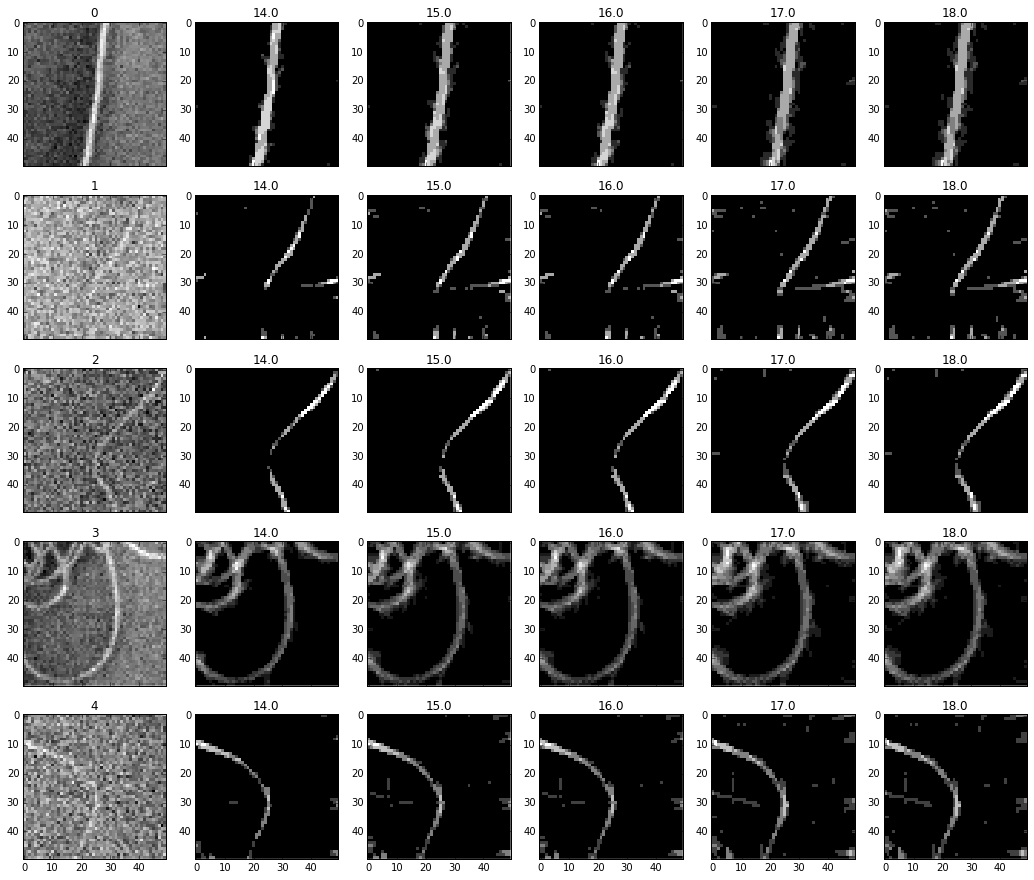

In [41]:
### L ###

# initial variables
k = 1.7
a = 10.0
L = 15.0 
N = 25
R = 15
threshold = 3.6

mfilter = ImgFilter(k, a, L, N, R, threshold)

# variable to test
Ls = [14.0,15.0,16.0,17.0,18.0]

fig, axs = plt.subplots(5,6,sharex = True, sharey=False, 
                        figsize=(6*3,5*3))

for i, im in enumerate(tset):
    for j in range(6):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title(i)
        else:
            mfilter.L = Ls[j-1]
            axs[i,j].imshow(mfilter(im), cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title('{}'.format(Ls[j-1]))

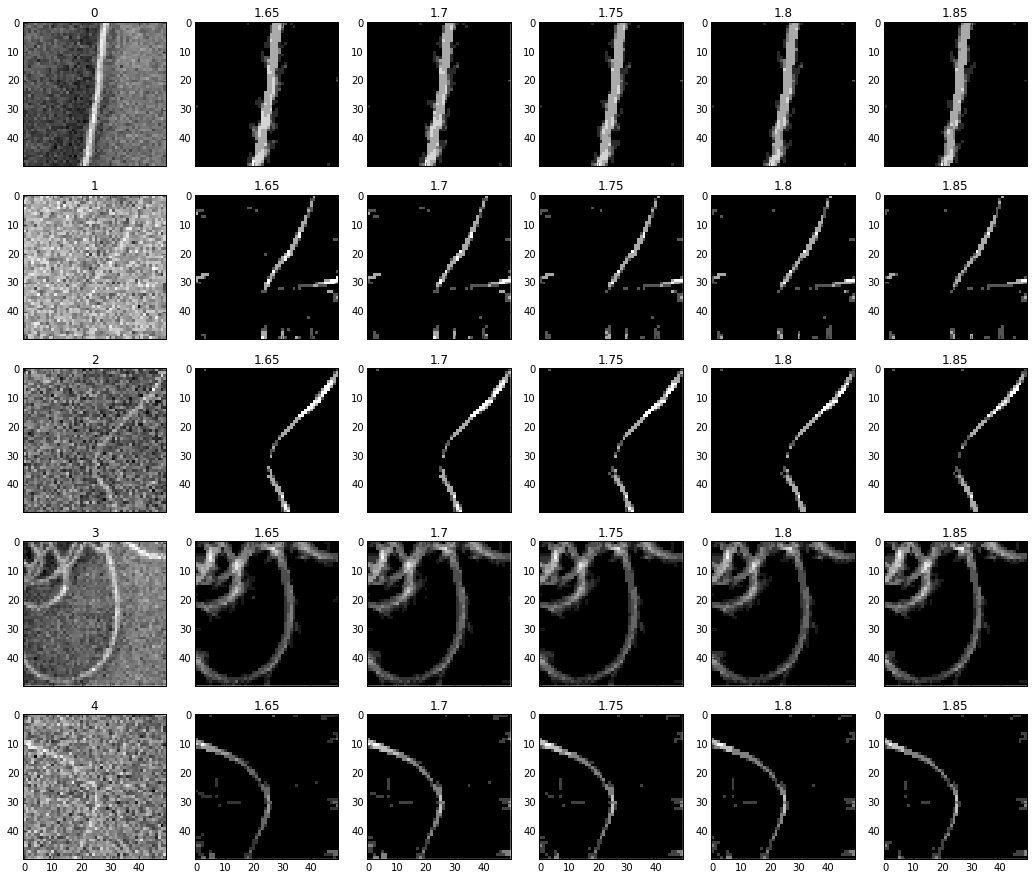

In [44]:
### k ###

# initial variables
k = 1.7
a = 10.0
L = 16.0
N = 25
R = 15
threshold = 3.6

mfilter = ImgFilter(k, a, L, N, R, threshold)

# variable to test
ks = [1.65,1.7,1.75,1.8,1.85]

fig, axs = plt.subplots(5,6,sharex = True, sharey=False, 
                        figsize=(6*3,5*3))

for i, im in enumerate(tset):
    for j in range(6):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title(i)
        else:
            mfilter.k = ks[j-1]
            axs[i,j].imshow(mfilter(im), cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title('{}'.format(ks[j-1]))

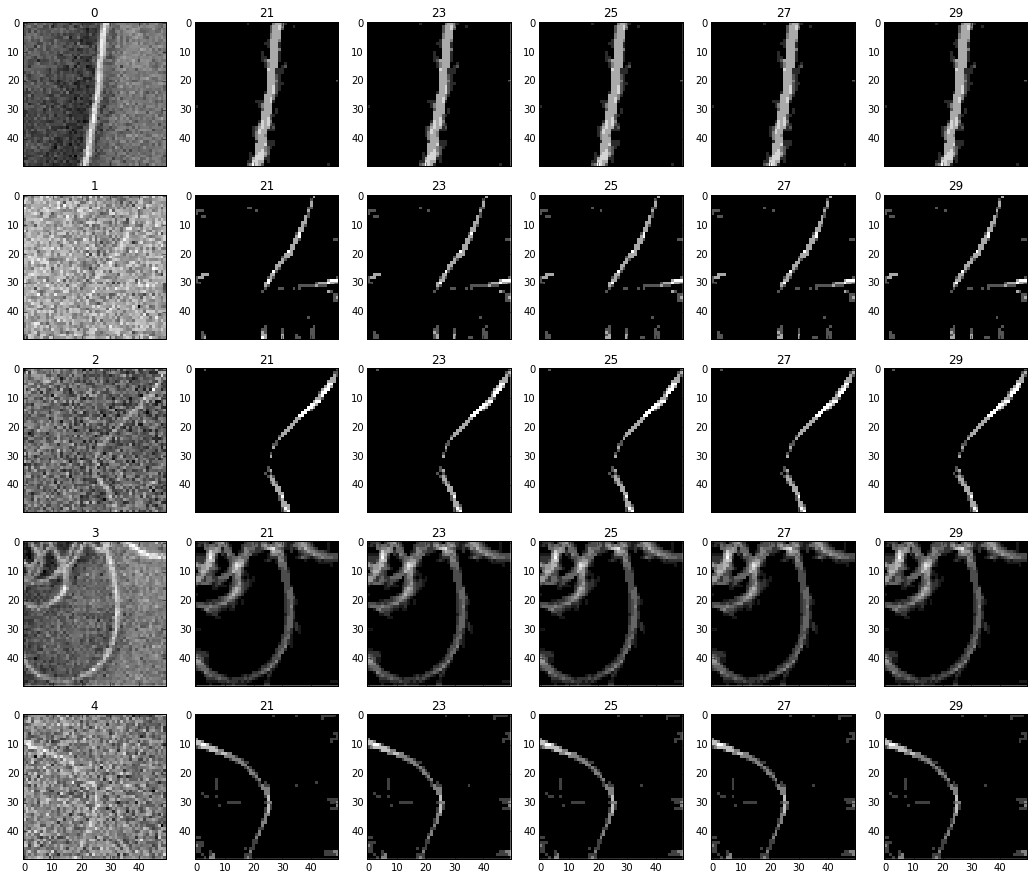

In [46]:
### N ###

# initial variables
k = 1.75
a = 10.0
L = 16.0
N = 25
R = 15
threshold = 3.6

mfilter = ImgFilter(k, a, L, N, R, threshold)

# variable to test
Ns = [21,23,25,27,29]

fig, axs = plt.subplots(5,6,sharex = True, sharey=False, 
                        figsize=(6*3,5*3))

for i, im in enumerate(tset):
    for j in range(6):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title(i)
        else:
            mfilter.N = Ns[j-1]
            axs[i,j].imshow(mfilter(im), cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title('{}'.format(Ns[j-1]))

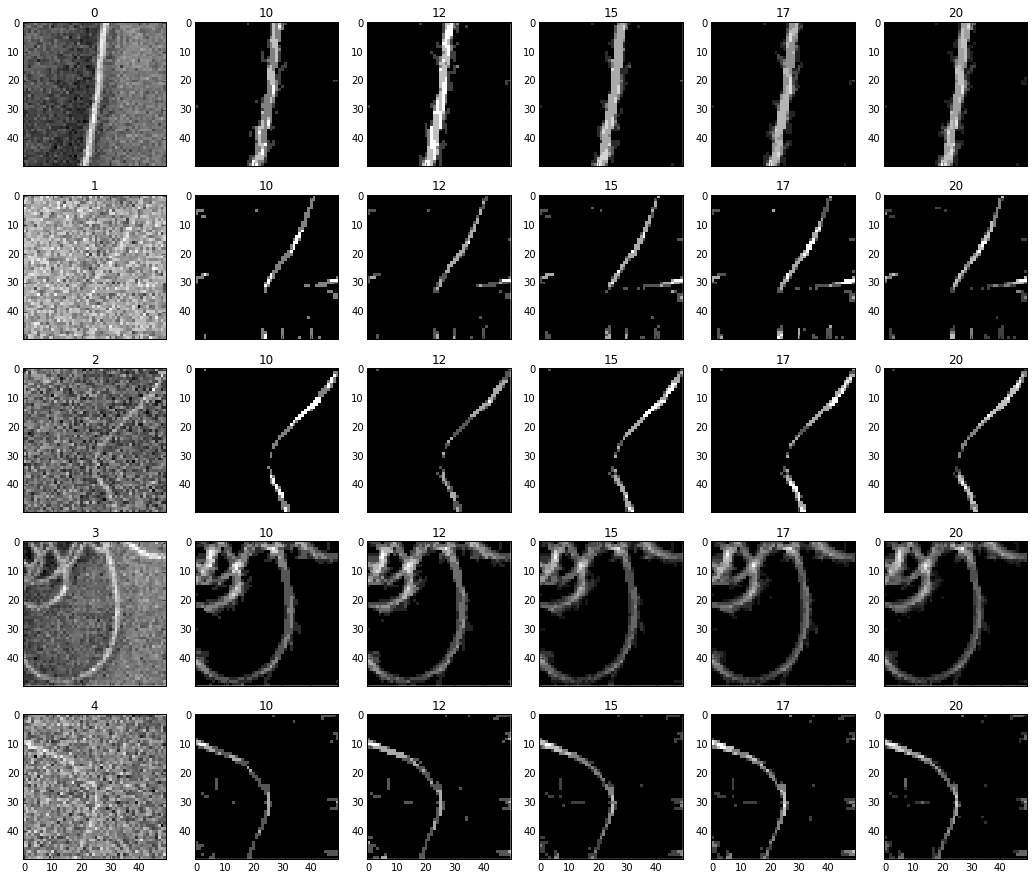

In [47]:
### R ###

# initial variables
k = 1.75
a = 10.0
L = 16.0
N = 25
R = 15
threshold = 3.6

mfilter = ImgFilter(k, a, L, N, R, threshold)

# variable to test
Rs = [10,12,15,17,20]

fig, axs = plt.subplots(5,6,sharex = True, sharey=False, 
                        figsize=(6*3,5*3))

for i, im in enumerate(tset):
    for j in range(6):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title(i)
        else:
            mfilter.R = Rs[j-1]
            axs[i,j].imshow(mfilter(im), cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title('{}'.format(Rs[j-1]))

### starting values

k = 1.8, a = 10.0, L = 18.0, N = 21, R = 12, threshold = 4

### after round 1

k = 1.7, a = 10.0, L = 15.0, N = 25, R = 15, threshold = 3.75

L kind of works backwards from what I would have expected. It looks like N just needs to be sufficiently large as to contain the whole sinc function as it is rotated. 

### after round 2

k = 1.75, a = 10.0, L = 16.0, N = 25, R = 15, threshold = 3.6

It looks like my initial guess was actually pretty close. None of these parameters are significantly changing my results now.

I need a way of connecting tubes that are not fully connected. It should do a few things... 

1. convert filtered image to binary
2. remove groups of pixels that are very small (area < a few pixels)
3. find the end points of lines (large groups?) 
4. connect endpoints with straight segments if they are within some specified radius (and in roughly the correct direction)

There seems to be some information about this here: http://www.programering.com/q/MjMxkzNwATg.html That is basically steps 3 and 4.

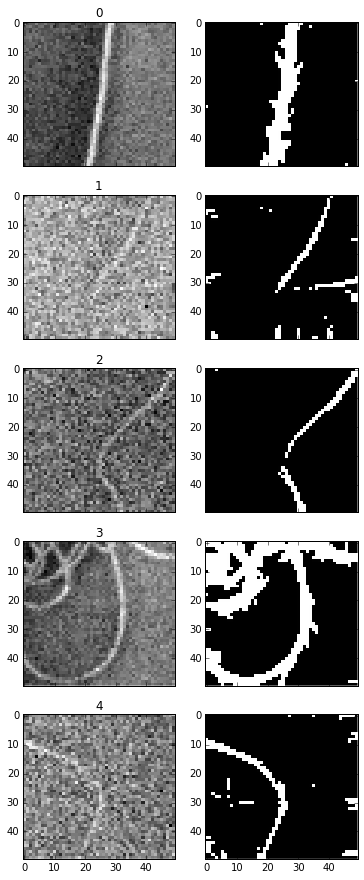

In [48]:
# step 1. create binary image from filter results

# initial variables
k = 1.75
a = 10.0
L = 16.0
N = 25
R = 15
threshold = 3.6

mfilter = ImgFilter(k, a, L, N, R, threshold)

fig, axs = plt.subplots(5,2,sharex = True, sharey=False, 
                       figsize=(2*3,5*3))

bim = np.zeros(tset.shape) # binary images
for i, im in enumerate(tset):
    for j in range(2):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title(i)
        else:
            bim[i] = mfilter(im) > 0
            axs[i, j].imshow(bim[i], cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')

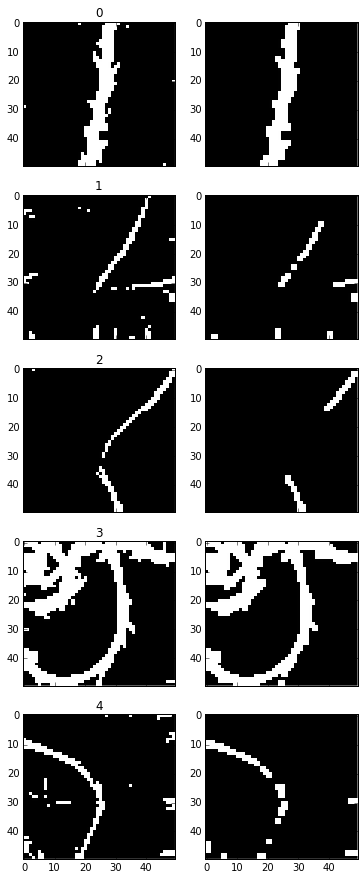

In [74]:
# first attempt at step 2, use a binary opening 
# unfortunately this makes steps 3 and 4 much harder

s = np.ones((2,2))

fig, axs = plt.subplots(5,2,sharex = True, sharey=False, 
                       figsize=(2*3,5*3))

for i, im in enumerate(bim):
    for j in range(2):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title(i)
        else:
            axs[i, j].imshow(ndimage.binary_opening(bim[i], structure=s),
                             cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')

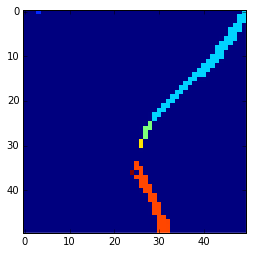

In [113]:
# instead try using label to find the connected regions and remove those 
# that have sizes less than some threshold

a = bim[2]

s = ndimage.generate_binary_structure(2,1)
label_im, num_labels = ndimage.label(a, structure=s)

sizes = ndimage.sum(a,label_im,range(1,num_labels+1)) #sizes of all labelled objects

plt.imshow(label_im, cmap = plt.cm.jet, aspect = 'equal', interpolation = 'None')

In [152]:
# I like these parameters as a start
# might want to change the structuring element to include nearest neighbors

def remove_smallest_features(b, cutoff):
    """ b is a binary image. drop all labelled features with sizes<cutoff """
    s = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype='uint8')
    label_im, num_labels = ndimage.label(b, structure=s)
    sizes = ndimage.sum(b,label_im,range(1,num_labels+1))
    
    mip = np.where(sizes<cutoff)[0] + 1
    drop_index = np.zeros(num_labels + 1, np.uint8)
    drop_index[mip] = 1
    drop = drop_index[label_im]
    return b-drop

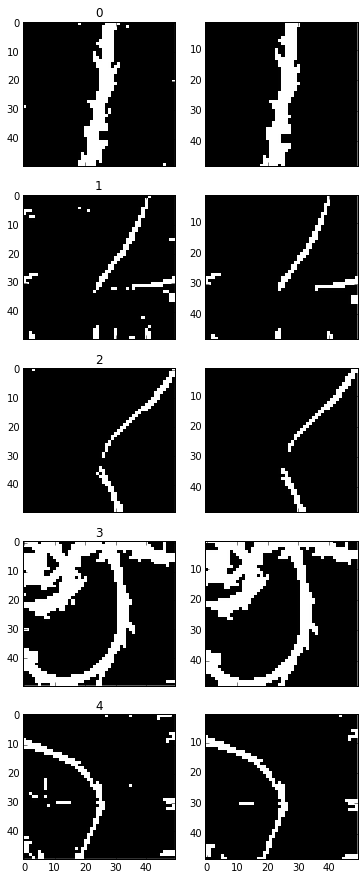

In [157]:
fig, axs = plt.subplots(5,2,sharex = True, sharey=False, 
                       figsize=(2*3,5*3))

for i, im in enumerate(bim):
    for j in range(2):
        if j == 0:
            axs[i,j].imshow(im, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'None')
            axs[i,j].set_title(i)
        else:
            axs[i, j].imshow(remove_smallest_features(im, 5),
                             cmap = plt.cm.gray, aspect = 'equal', interpolation = 'None')

That's not too bad for steps 1 and 2.

On to figuring out steps 3 and 4 based on this strange link: http://www.programering.com/q/MjMxkzNwATg.html

In [159]:
from scipy.spatial import ConvexHull, Delaunay

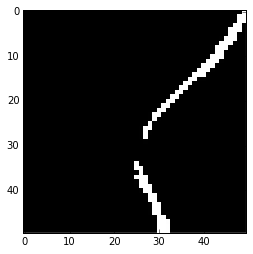

In [165]:
b = remove_smallest_features(bim[2], 5)
plt.imshow(b, cmap = plt.cm.gray, aspect = 'equal', interpolation = 'None')

<matplotlib.colorbar.Colorbar instance at 0x1149a08c0>

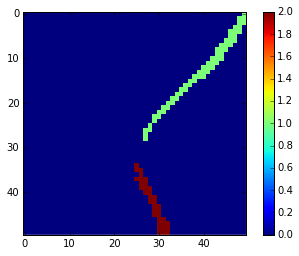

In [257]:
s = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype='uint8')
blabel, num_labels = ndimage.label(b, structure=s)
plt.imshow(blabel, cmap = plt.cm.jet, aspect = 'equal', interpolation = 'None')
plt.colorbar()

This looks close to what I want: http://okomestudio.net/biboroku/?p=1768

There might be a problem with this idea. If the two endpoints I need to connect have the same label, this fails. The method in that link will work well, only if I want to connect two different labels.

I think I want a two fold approach, use a kdtree to find the nearest neighbors of two labelled objects and connect them. Also, use a convex hull to find the vertices of a single labelled object and connect them.

In [346]:
# need a function that gets a list of points from a labelled object
def get_points_list(labelled_im, label):
    """ labelled_im is the output of ndimage.label()
        label is the label of the object I'm interested in """
    return np.column_stack(np.where(labelled_im == label))

# use that to get a list of lists of points for all labelled objects
def get_all_points_lists(labelled_im, num_labels):
    """ return a list of lists of tuples containing all of the points for
        each label in labelled_im """
    points_list = []
    for l in range(1,num_labels+1):
        points_list.append(get_points_list(labelled_im, l))
    return points_list

(0, 50)

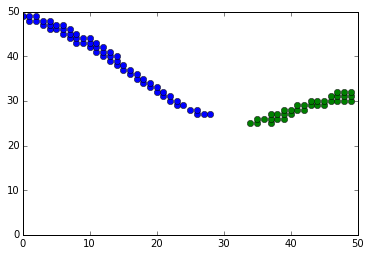

In [439]:
# from here on points_list will be the relevant object.

b = remove_smallest_features(bim[2], 5)
blabel, num_labels = ndimage.label(b, structure=s)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for p in get_all_points_lists(blabel, num_labels):
    ax.plot(p[:,0], p[:,1], 'o')
ax.set_xlim(0,50)
ax.set_ylim(0,50)

(0, 50)

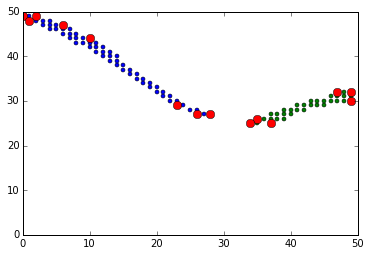

In [438]:
# the convex hull transform can be used to find the vertices of each labelled object

b = remove_smallest_features(bim[2], 5)
blabel, num_labels = ndimage.label(b, structure=s)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

vertices = [] # each entry is the set of vertices for the label with that index+1
for pnts in get_all_points_lists(blabel, num_labels):
    hull = ConvexHull(pnts)
    ax.plot(pnts[:,0], pnts[:,1], 'o', ms=4)
    vertices.append(pnts[hull.vertices])
    ax.plot(pnts[hull.vertices,0], pnts[hull.vertices,1], 'ro', ms=8)
ax.set_xlim(0,50)
ax.set_ylim(0,50)

The vertices are ordered in a counter clockwise direction to close all of the points in the object. That means if I want to connect points in the same label, I can immediately throw out any possible connections of adjacent vertices.

Proceed for now assuming that I don't need to worry about the case where vertices on the same object need to be connected.

In [319]:
# use kdtree to find nearest neighbors

from scipy.spatial import KDTree, cKDTree

In [402]:
def remove_repeated_rows(a):
    """ does exactly what it says. from here: http://stackoverflow.com/
    questions/8560440/removing-duplicate-columns-and-rows-from-a-numpy-2d-array """
    
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

def get_nnidx(set1, set2, r, k=1):
    """ create a kd tree for set1. find the nearest set1 point to each of the set2 points """
    tree = cKDTree(set1)
    dist, idx = tree.query(set2, k=k, eps=0, p=2, distance_upper_bound=r)
    return idx

def find_pairs_to_connect(vertices, r, k=1):
    
    pairs = []
    for i in range(len(vertices)):
        tree = cKDTree(vertices[i])
        L = len(vertices[i])
        for j in range(len(vertices)):
            if j==i:
                continue
            else:
                # print i, j
                dist, nnidx = tree.query(vertices[j], k=k, eps=0, p=2, distance_upper_bound=r)
                for m, nn in enumerate(nnidx):
                    if nn<L:
                        pairs.append(vertices[i][nn])
                        pairs.append(vertices[j][ m])
                        # print 'connect {0} to {1}'.format(vertices[i][nn], vertices[j][m])
    return np.array(pairs)

In [1]:
b = remove_smallest_features(bim[1], 5)
blabel, num_labels = ndimage.label(b, structure=s)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

vertices = [] # each entry is the set of vertices for the label with that index+1
for pnts in get_all_points_lists(blabel, num_labels):
    try: 
        hull = ConvexHull(pnts)
    except:
        continue
    ax.plot(pnts[:,0], pnts[:,1], 'o', ms=4)
    vertices.append(pnts[hull.vertices])
    ax.plot(pnts[hull.vertices,0], pnts[hull.vertices,1], 'ro', ms=8)
ax.set_xlim(0,50)
ax.set_ylim(0,50)

pairs = find_pairs_to_connect(vertices, 15)
# poly = remove_repeated_rows(pairs) #these are sort of the vertices of a polygon to fill
if pairs.size!=0:
    ax.plot(pairs[:,0],pairs[:,1], 'r-', lw=2)

NameError: name 'remove_smallest_features' is not defined

In [ ]:
3